In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Carol Lake Mine.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Minntac.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Ipoti - 2.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Conceicao 3.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Santa Paulina.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Cetinkaya.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Poltava Mine.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Pena Colorada.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Alegria.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/NR_Komu 6.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Itatiaiucu East Mine.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Kaunisvaara.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/Kiruna 2.geojson
/kaggle/input/mine-segment-iron-eunasani/GeoJSONs/United Taconite.geojson
/kaggle/input/m

In [2]:
pip install torchgeo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.0/605.0 kB 16.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.6/851.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torchgeo
from torchgeo.datasets import RasterDataset,VectorDataset,stack_samples,IntersectionDataset,unbind_samples, utils,random_bbox_assignment
from rasterio.crs import CRS
from torchgeo.samplers import RandomBatchGeoSampler,RandomGeoSampler,Units,GridGeoSampler
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torch
import kornia.augmentation as K
from sklearn.metrics import jaccard_score

def scale(item: dict):
    item['image'] = (item['image'] - item['image'].min())/(item['image'].max()-item['image'].min()+ 1e-8)
    return item

def scale_image(item: dict):
    if item["image"].max() == 0:
        item["valid"] = False  # Or remove, or log
    else:
        item["image"] = (item["image"] - item["image"].min()) / (item["image"].max() - item["image"].min() + 1e-8)
        item["valid"] = True
    return item

transforms = K.AugmentationSequential(
    
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    #K.Resize((256,256),resample='nearest'),
    data_keys=['image','mask'],
    same_on_batch=True,
    keepdim=True
)


# Define the custom GeoTiffDataset class with normalization
class GeoTiffDataset(RasterDataset):
    filename_glob = "*.tif"
    is_image = True
    transforms=None
    #crs=CRS.from_epsg('32631')
    
class LabelDataset(VectorDataset):
    filename_glob = "*.geojson"  # Look for GeoJSON files
    #crs=CRS.from_epsg('32631')
    transforms=None
    

# Initialize the label dataset (GeoJSON labels)
Vector = LabelDataset(
    paths=[r"/kaggle/input/mine-segment-iron-eunasani/GeoJSONs"]# Raw string for Windows paths
)
Raster=GeoTiffDataset(paths=[r'/kaggle/input/mine-segment-iron-eunasani/GeoTiffs'],res=10,transforms=scale_image)

print('length of Vector Files :',len(Vector))
print('length of Train Raster Files :',len(Raster))
#print('length of Validation Raster Files :',len(val_raster))


Train_vector,val_vector=random_bbox_assignment(Vector,lengths=[0.7,0.3])
train_ds=IntersectionDataset(Raster,Train_vector)
valid_ds=IntersectionDataset(Raster,val_vector)

print('len of train_ds',train_ds)
print('len of val_ds',valid_ds)

train=RandomGeoSampler(dataset=train_ds,size=256,length=700)
valid=RandomGeoSampler(dataset=valid_ds,size=256,length=300)



# Adjust the batch size according to your GPU memory
train_dataloader = DataLoader(dataset=
    train_ds, sampler=train, collate_fn=stack_samples,batch_size=8
)
valid_dataloader = DataLoader(dataset=
    valid_ds, sampler=valid, collate_fn=stack_samples,batch_size=8
)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()


print(train_batch['image'].shape) 
print(train_batch['mask'].shape) 

batch = next(iter(valid_dataloader))
print("Image dtype:", batch['image'].dtype)
print("Image min/max:", batch['image'].min().item(), batch['image'].max().item())
print("Mask unique values:", torch.unique(batch['mask']))
print("Image dtype:", batch['image'].shape)
batch_train = next(iter(train_dataloader))

length of Vector Files : 162
length of Train Raster Files : 42
Converting LabelDataset CRS from EPSG:4326 to EPSG:32615
Converting LabelDataset res from (0.0001, 0.0001) to (10, 10)
Converting LabelDataset CRS from EPSG:4326 to EPSG:32615
Converting LabelDataset res from (0.0001, 0.0001) to (10, 10)
len of train_ds IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=532641.9879723694, maxx=15763268.191456687, miny=-3301129.7886151313, maxy=15625797.535698421, mint=0.0, maxt=9.223372036854776e+18)
    size: 217
len of val_ds IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=-673975.2826785257, maxx=15271523.058636053, miny=-3299208.872328273, maxy=15556265.943876771, mint=0.0, maxt=9.223372036854776e+18)
    size: 85
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
Image dtype: torch.float32
Image min/max: 0.0 1.0
Mask unique values: tensor([0, 1])
Image dtype: torch.Size([8, 3, 256, 256])


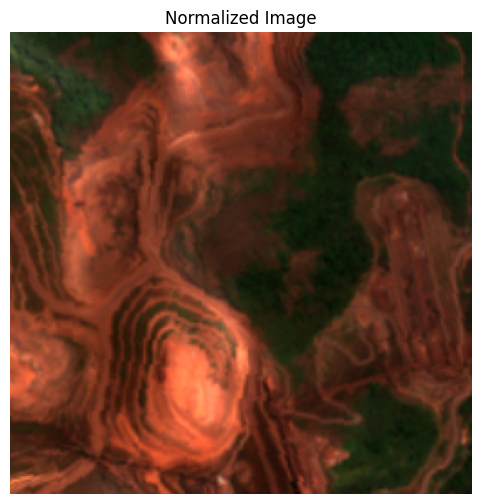

Text(0.5, 1.0, 'Mask')

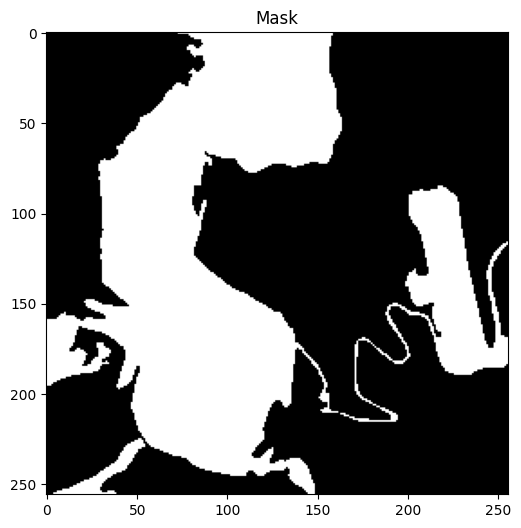

In [4]:

# Assume image has shape [3, H, W]
image=batch_train['image'][0]
mask=batch_train['mask'][0]
img = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)

# If img is float32 but 32-255, we normalize it for display:
#img = (img - img.min()) / (img.max() - img.min())  # Now 0-1

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Normalized Image")
plt.axis('off')
plt.show()

# Plot mask as well
plt.figure(figsize=(6, 6))
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.title("Mask")


In [5]:
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.resnet import ResNet101_Weights

model = deeplabv3_resnet101(weights=None, num_classes=2)
weights_backbone=ResNet101_Weights.IMAGENET1K_V1

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 78.1MB/s] 


In [6]:
backbone = model.get_submodule('backbone')

conv = torch.nn.modules.conv.Conv2d(
    in_channels=3,
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False,
)
backbone.register_module('conv1', conv)

pred = model(torch.randn(8, 3, 256, 256))
pred['out'].shape

torch.Size([8, 2, 256, 256])

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
import torch
from torch.utils.data import DataLoader

from collections.abc import Callable
def train_loop(
    epochs: int,
    train_dl: DataLoader,
    val_dl: DataLoader | None,
    model: torch.nn.Module,
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    acc_fns: list | None = None,
    batch_tfms: Callable | None = None,
):
    # size = len(dataloader.dataset)
    cuda_model = model.to(device)

    for epoch in range(epochs):
        accum_loss = 0
        for batch in train_dl:
            if batch_tfms is not None:
                X, y = batch_tfms(batch['image'], batch['mask'])
                X = X.to(device)
                y = y.to(device).long()
            else:
                X = batch['image'].to(device)
                y = batch['mask'].type(torch.long).to(device)

            
            
            pred = cuda_model(X)['out']
            loss = loss_fn(pred, y)
            

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
           

            # update the accum loss
            accum_loss += float(loss) / len(train_dl)

        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.0] * len(acc_fns)

            with torch.no_grad():
                for batch in val_dl:
                    if batch_tfms is not None:
                        X, y = batch_tfms(batch['image'], batch['mask'])
                        X = X.to(device)
                        y = y.to(device).long()
                    else:
                        X = batch['image'].type(torch.float32).to(device)
                        y = batch['mask'].type(torch.long).to(device)

                    

                    pred = cuda_model(X)['out']

                    for i, acc_fn in enumerate(acc_fns):
                        acc[i] = float(acc[i] + acc_fn(pred, y) / len(val_dl))

            # at the end of the epoch, print the errors, etc.
            print(
                f'Epoch {epoch}: Train Loss={accum_loss:.5f} - Accs={[round(a, 3) for a in acc]}'
            )
        else:
            print(f'Epoch {epoch}: Train Loss={accum_loss:.5f}')

In [9]:
def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc


def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.0)


class_weights = torch.tensor([0.1, 0.9]).to(device)  # Adjust based on class freq
def loss(p, t):
    return torch.nn.functional.cross_entropy(p, t.squeeze(),weight=class_weights)


In [10]:
# adjust number of epochs depending on the device
if torch.cuda.is_available():
    num_epochs = 50
else:
    # if GPU is not available, just make 1 pass and limit the size of the datasets
    num_epochs = 1

    # by limiting the length of the sampler we limit the iterations in each epoch
    train_dataloader.sampler.length = 8
    valid_dataloader.sampler.length = 8

# train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
train_loop(
    num_epochs,
    train_dataloader,
    valid_dataloader,
    model,
    loss,
    optimizer,
    acc_fns=[oa, iou],
   
)

Epoch 0: Train Loss=0.48508 - Accs=[0.693, 0.4]
Epoch 1: Train Loss=0.39583 - Accs=[0.73, 0.439]
Epoch 2: Train Loss=0.40827 - Accs=[0.695, 0.384]
Epoch 3: Train Loss=0.39780 - Accs=[0.759, 0.446]
Epoch 4: Train Loss=0.33312 - Accs=[0.753, 0.432]
Epoch 5: Train Loss=0.40996 - Accs=[0.68, 0.371]
Epoch 6: Train Loss=0.38021 - Accs=[0.652, 0.418]
Epoch 7: Train Loss=0.38221 - Accs=[0.715, 0.417]
Epoch 8: Train Loss=0.38844 - Accs=[0.742, 0.418]
Epoch 9: Train Loss=0.38430 - Accs=[0.677, 0.406]
Epoch 10: Train Loss=0.34974 - Accs=[0.672, 0.402]
Epoch 11: Train Loss=0.35382 - Accs=[0.734, 0.435]
Epoch 12: Train Loss=0.35471 - Accs=[0.734, 0.458]
Epoch 13: Train Loss=0.36820 - Accs=[0.703, 0.441]
Epoch 14: Train Loss=0.33321 - Accs=[0.754, 0.449]
Epoch 15: Train Loss=0.34261 - Accs=[0.712, 0.44]
Epoch 16: Train Loss=0.32102 - Accs=[0.746, 0.464]
Epoch 17: Train Loss=0.35359 - Accs=[0.743, 0.476]
Epoch 18: Train Loss=0.29296 - Accs=[0.745, 0.42]
Epoch 19: Train Loss=0.30899 - Accs=[0.74, 0.43

In [11]:
import torch
torch.save(model.state_dict(),r'/kaggle/working/Mine_Detection_Resnet101_Epochs_50_No_Weights.pth')

In [ ]:
def check_dataloader_dtypes(dataloader, num_batches=None):
    for batch_idx, batch in enumerate(dataloader):
        if isinstance(batch, dict):
            images = batch['image']
            masks = batch['mask']
            ids = batch.get('image_id', None)  # Add this if you store image paths or IDs
        else:
            images, masks = batch
            ids = None

        for i in range(images.size(0)):
            image = images[i]
            mask = masks[i]
            img_id = ids[i] if ids is not None else f"Batch {batch_idx}, Index {i}"

            min_val = image.min().item()
            max_val = image.max().item()

            print(f"[{img_id}] Image dtype: {image.dtype}, min: {min_val:.3f}, max: {max_val:.3f}")
            print(f"[{img_id}] Mask dtype: {mask.dtype}, unique values: {torch.unique(mask)}")

            if max_val == 0.0 and min_val == 0.0:
                print(f"⚠️ BLACK IMAGE FOUND: {img_id}")

        if num_batches and batch_idx + 1 >= num_batches:
            break
check_dataloader_dtypes(train_dataloader)

In [ ]:
model.eval()

In [ ]:
import rasterio
with rasterio.open(r"/kaggle/input/mine-detection/GeoTiffs/sentinel-2-l2a_visual_S2C_MSIL2A_20250416T095051_R079_T32PKU_20250416T151319.tif") as f:
    image = f.read()
    profile = f.profile
    